In [1]:
import numpy as np
import pandas as pd
import re
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout, Embedding, GRU, LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical

from wordcloud import WordCloud

# Ignore warnings
warnings.filterwarnings('ignore')

In [2]:
# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\769800.ADIR\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\769800.ADIR\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\769800.ADIR\AppData\Roaming\nltk_data...


True

In [3]:
def preprocess_text(text):
    '''Tokenizes, lemmatizes, removes stopwords, and optionally stems the input text.'''
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)
    tokens = [word for word in tokens if word.lower() not in ['rt'] and not word.isdigit() and len(word) > 1]
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]
    stop_words = set(stopwords.words('english')) | {'to', 'of', 'in', 'and', 'is', 'for', 'on', 'are', 'the', 'that', 'with', 'from', 'have', 'has', 'this', 'be', 'it', 'at', 'as', 'we'}
    filtered_tokens = [word.lower() for word in lemmatized_tokens if word.lower() not in stop_words]
    replacements = {'https?://\S+|www\.\S+': '', r'\bco\b': '', r'\bwa\b': '', r'\bamp\b': '', r'\bhttp\b': '', r'\bha\b': ''}
    for pattern, repl in replacements.items():
        filtered_tokens = [re.sub(pattern, repl, word) for word in filtered_tokens]
    porter = PorterStemmer()
    stemmed_tokens = [porter.stem(word) for word in filtered_tokens]
    return ' '.join(stemmed_tokens)

In [4]:
def load_and_preprocess_data(files):
    '''Loads, merges, and preprocesses data from specified file paths.'''
    dfs = [pd.read_csv(file)[['original_text', 'sentiment']] for file in files]
    merged_df = pd.concat(dfs, ignore_index=True)
    merged_df.dropna(subset=['original_text'], inplace=True)
    merged_df['sentiment'] = merged_df['sentiment'].replace(['pos', 'neu', 'neg'], ['positive', 'neutral', 'negative'])
    merged_df['clean_tweet'] = merged_df['original_text'].apply(preprocess_text)
    merged_df.drop_duplicates(inplace=True)
    return merged_df

In [5]:
def balance_dataset(merged_df):
    '''Balances the dataset to have equal representation for all sentiment classes and visualizes the balance.'''
    before_counts = merged_df['sentiment'].value_counts()
    max_samples = max(before_counts)
    balanced_df = pd.DataFrame()
    for sentiment, group in merged_df.groupby('sentiment'):
        balanced_group = resample(group, replace=True, n_samples=max_samples, random_state=42)
        balanced_df = pd.concat([balanced_df, balanced_group])
    balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)
    # Visualize average word length by sentiment
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot distributions of word lengths
    sentiments = ['positive', 'negative', 'neutral']
    colors = ['red', 'green', 'blue']
    for ax, sentiment, color in zip(axs[0], sentiments, colors):
        word_lengths = balanced_df[balanced_df['sentiment'] == sentiment]['clean_tweet'].str.split().apply(lambda x: np.mean([len(i) for i in x]))
        sns.histplot(word_lengths, ax=ax, color=color, kde=True)
        ax.set_title(f'{sentiment.capitalize()} Word Length')

    # Plot sentiment counts before and after balancing
    plt.subplot(2, 2, 3)
    before_counts.plot(kind='bar', color='blue')
    plt.title('Sentiment Counts (Before Oversampling)')
    plt.xlabel('Sentiment')
    plt.ylabel('Count')

    plt.subplot(2, 2, 4)
    balanced_df['sentiment'].value_counts().plot(kind='bar', color='orange')
    plt.title('Sentiment Counts (After Oversampling)')
    plt.xlabel('Sentiment')
    plt.ylabel('Count')

    plt.tight_layout()
    plt.show()
    
    return balanced_df, before_counts, balanced_df['sentiment'].value_counts()

def generate_word_cloud(sentiment, text_column, balanced_data):
    '''Generates a word cloud for a given sentiment from the specified text column.'''
    text = ' '.join(balanced_data[balanced_data['sentiment'] == sentiment][text_column])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {sentiment.capitalize()} Sentiment')
    plt.show()

def plot_frequency_distribution(all_words):
    '''Plots the frequency distribution of words in the data.'''
    freq_dist = nltk.FreqDist(all_words)
    top_words = freq_dist.most_common(25)
    words, frequencies = zip(*top_words)
    plt.figure(figsize=(12, 6))
    plt.bar(words, frequencies, color='blue')
    plt.title('Top 25 most common words')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()


In [6]:
def evaluate_model(y_true, y_pred_proba, class_labels, model_name="Model"):
    """
    Evaluates the model's performance using a confusion matrix and classification report.
    
    Parameters:
        y_true (numpy.array or list): True labels, either in one-hot encoded format or as integers.
        y_pred_proba (numpy.array): Prediction probabilities from the model.
        class_labels (list): List of class labels.
        model_name (str): Name of the model for display purposes.
    """
    if y_true.ndim > 1:
        y_true_indices = y_true.argmax(axis=1)
    else:
        y_true_indices = y_true
    
    y_pred_indices = y_pred_proba.argmax(axis=1)
    
    cm = confusion_matrix(y_true_indices, y_pred_indices)
    report = classification_report(y_true_indices, y_pred_indices, target_names=class_labels)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()
    
    print(f"Classification Report - {model_name}:\n{report}")

In [7]:
def train_model(X_train, X_test, y_train, y_test, vectorization='tfidf', classifier='nb', hyperparameters=None):
    '''Trains and evaluates a model based on specified classifier and vectorization.'''
    if vectorization == 'tfidf':
        vectorizer = TfidfVectorizer()
    else:
        vectorizer = CountVectorizer()
    X_train_vectorized = vectorizer.fit_transform(X_train)
    X_test_vectorized = vectorizer.transform(X_test)
    if classifier == 'nb':
        model = MultinomialNB()
        param_grid = {'alpha': [0.1, 0.5, 1.0]}
    else:
        model = RandomForestClassifier()
        param_grid = {'n_estimators': [100, 200], 'max_depth': [10, 20]}
    if hyperparameters:
        grid_search = GridSearchCV(model, param_grid, cv=5)
        grid_search.fit(X_train_vectorized, y_train)
        model = grid_search.best_estimator_
    model.fit(X_train_vectorized, y_train)
    y_pred_proba = model.predict_proba(X_test_vectorized)
    evaluate_model(y_test, y_pred_proba, ['positive', 'negative', 'neutral'], model_name=f'{classifier.upper()} ({vectorization.upper()})')
    return model

In [8]:
def plot_history(history, model_name):
    """
    Plots training and validation accuracy and loss over epochs.
    
    Parameters:
        history: History object from model training.
        model_name (str): Name of the model for display purposes.
    """
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Training vs Validation Accuracy - {model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Training vs Validation Loss - {model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()


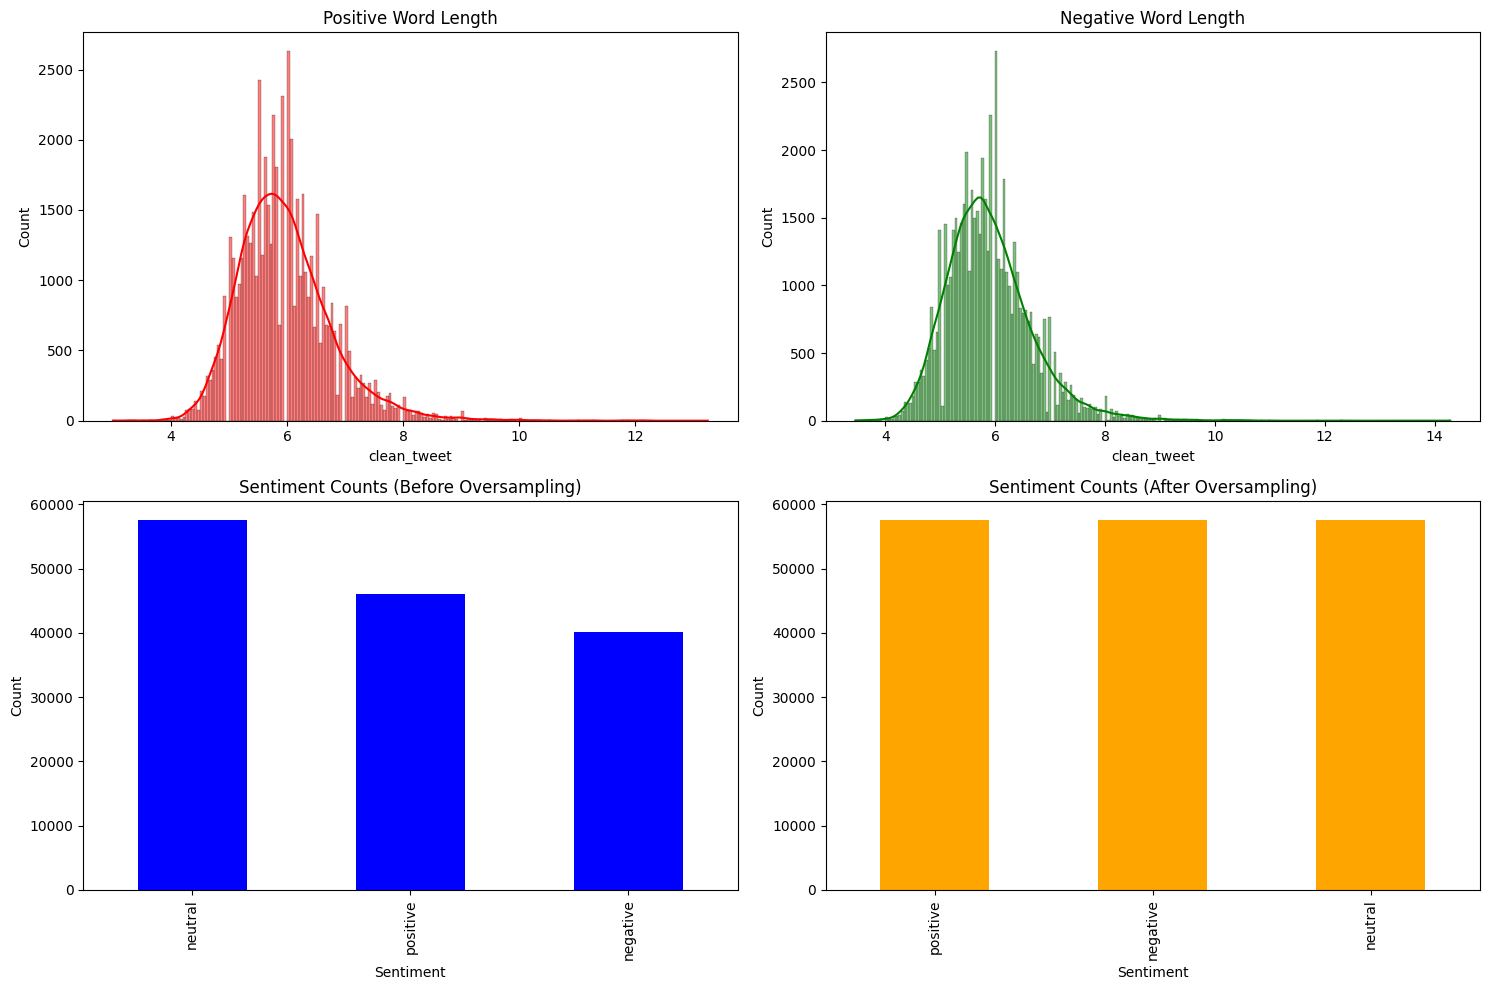

In [9]:
# Data processing and training
files = ['Covid-19 Twitter Dataset (Apr-Jun 2020).csv']
preprocessed_data = load_and_preprocess_data(files)
balanced_data, before_counts, after_counts = balance_dataset(preprocessed_data)

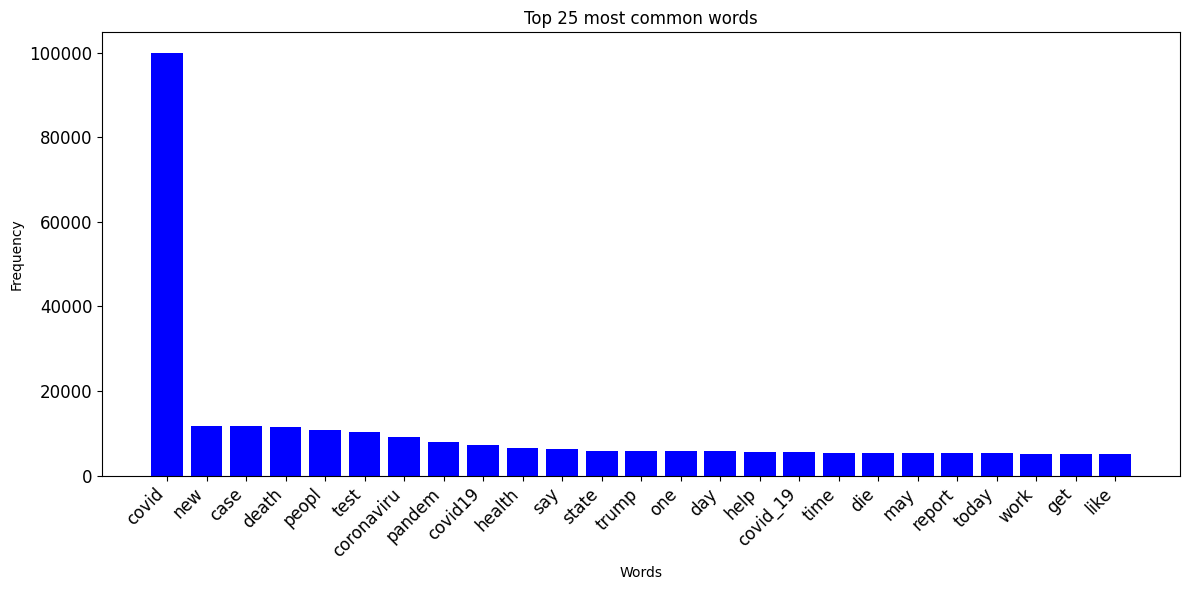

In [11]:
all_words = []
for tweet in balanced_data['clean_tweet']:
    all_words.extend(tweet.split())
plot_frequency_distribution(all_words)

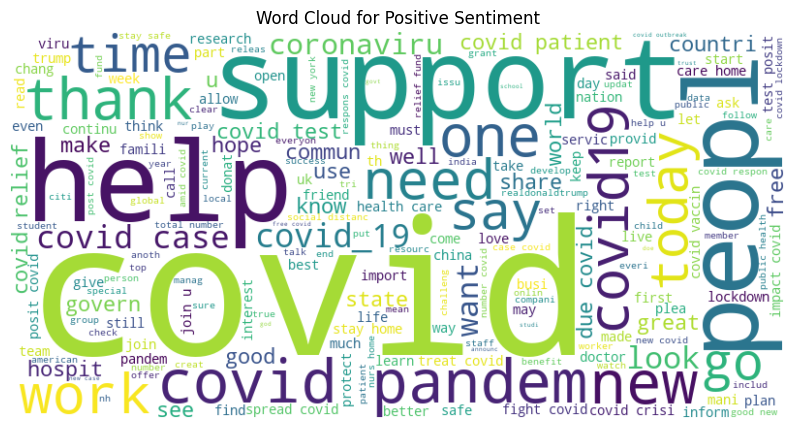

In [12]:
generate_word_cloud('positive', 'clean_tweet', balanced_data)

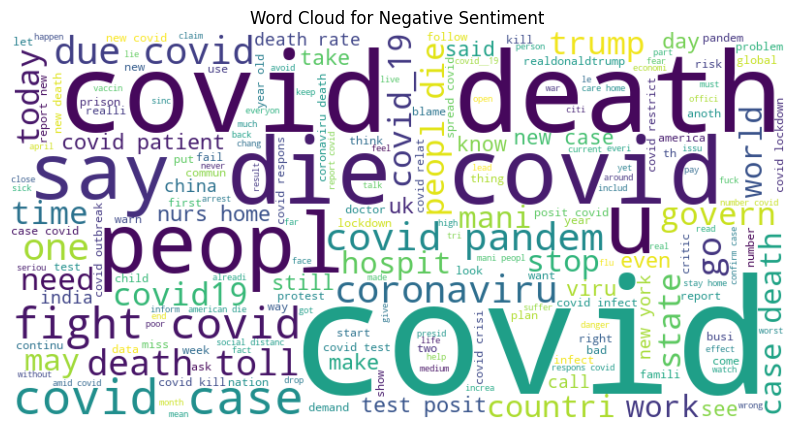

In [13]:
generate_word_cloud('negative', 'clean_tweet', balanced_data)

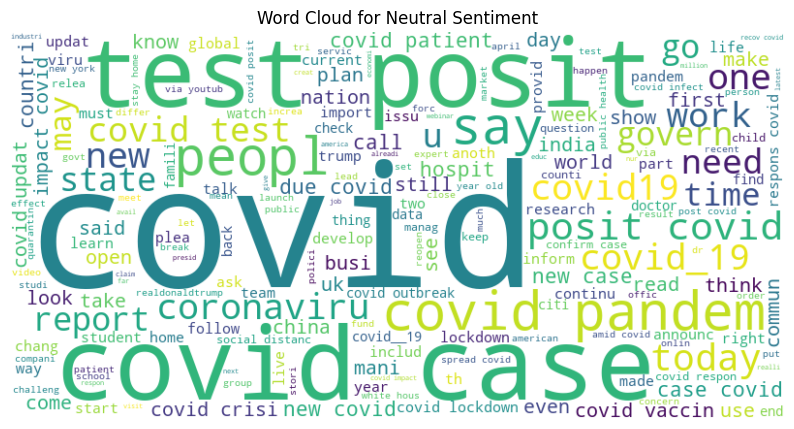

In [14]:
generate_word_cloud('neutral', 'clean_tweet', balanced_data)

In [15]:
print("Before Balancing:\n", before_counts)
print("After Balancing:\n", after_counts)

Before Balancing:
 neutral     57585
positive    46125
negative    40192
Name: sentiment, dtype: int64
After Balancing:
 positive    57585
negative    57585
neutral     57585
Name: sentiment, dtype: int64


In [16]:
X = balanced_data['clean_tweet']
y = balanced_data['sentiment']

In [17]:
# Encode the labels for traditional machine learning models
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

#### TRAINING A NAIVE BAYES WITH TFIDF

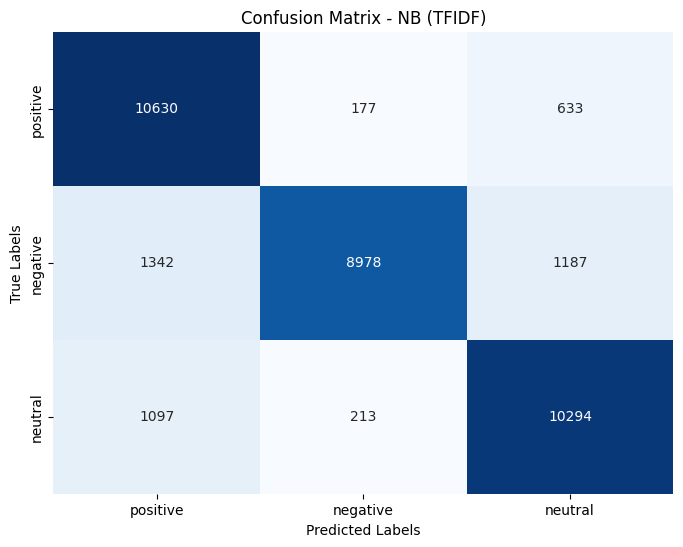

Classification Report - NB (TFIDF):
              precision    recall  f1-score   support

    positive       0.81      0.93      0.87     11440
    negative       0.96      0.78      0.86     11507
     neutral       0.85      0.89      0.87     11604

    accuracy                           0.87     34551
   macro avg       0.87      0.87      0.87     34551
weighted avg       0.87      0.87      0.87     34551



In [19]:
model_nb_tfidf = train_model(X_train, X_test, y_train, y_test, vectorization='tfidf', classifier='nb',hyperparameters={'alpha': [0.1, 0.5, 1.0]})

#### TRAINING A NAIVE BAYES WITH CBOW

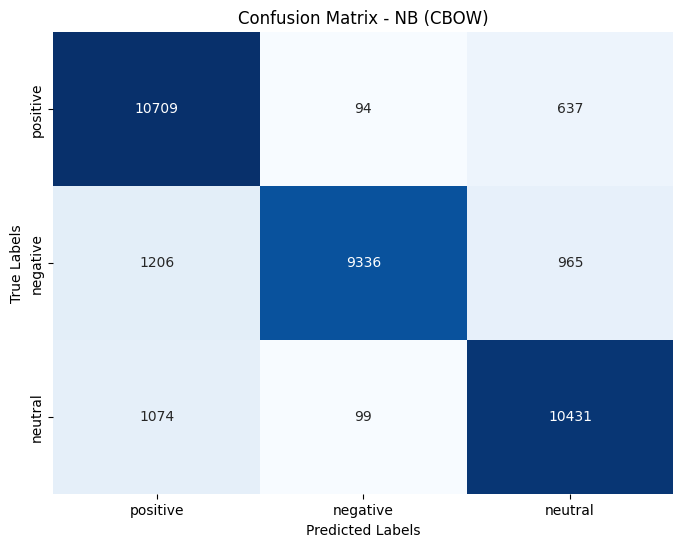

Classification Report - NB (CBOW):
              precision    recall  f1-score   support

    positive       0.82      0.94      0.88     11440
    negative       0.98      0.81      0.89     11507
     neutral       0.87      0.90      0.88     11604

    accuracy                           0.88     34551
   macro avg       0.89      0.88      0.88     34551
weighted avg       0.89      0.88      0.88     34551



In [20]:
model_nb_cbow = train_model(X_train, X_test, y_train, y_test, vectorization='cbow', classifier='nb',hyperparameters={'alpha': [0.1, 0.5, 1.0]})

#### TRAIN A RANDOM FOREST CLASSIFIER WITH TFIDF

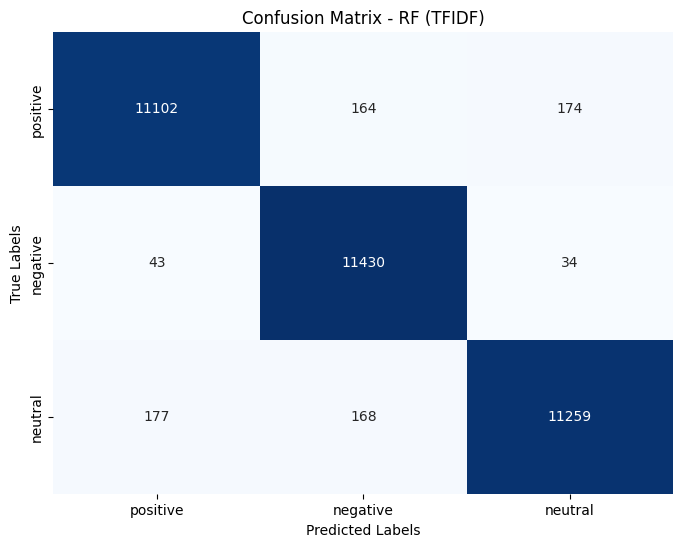

Classification Report - RF (TFIDF):
              precision    recall  f1-score   support

    positive       0.98      0.97      0.98     11440
    negative       0.97      0.99      0.98     11507
     neutral       0.98      0.97      0.98     11604

    accuracy                           0.98     34551
   macro avg       0.98      0.98      0.98     34551
weighted avg       0.98      0.98      0.98     34551



In [21]:
model_rf_cbow = train_model(X_train, X_test, y_train, y_test, vectorization='tfidf', classifier='rf')

#### TRAIN A RANDOM FOREST WITH CBOW

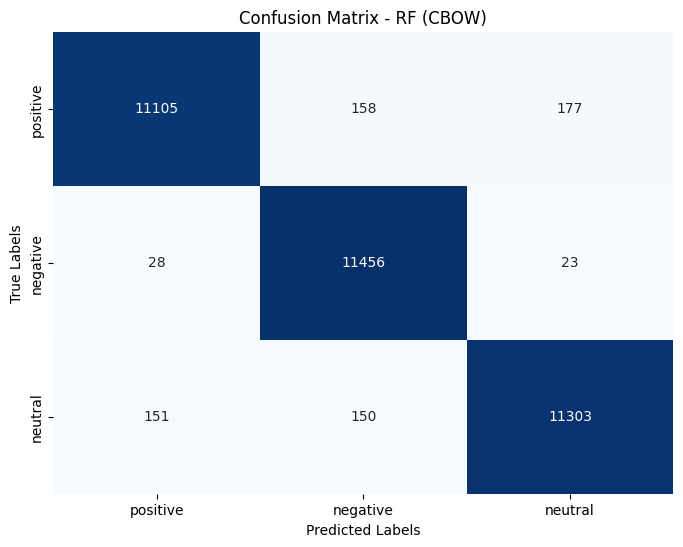

Classification Report - RF (CBOW):
              precision    recall  f1-score   support

    positive       0.98      0.97      0.98     11440
    negative       0.97      1.00      0.98     11507
     neutral       0.98      0.97      0.98     11604

    accuracy                           0.98     34551
   macro avg       0.98      0.98      0.98     34551
weighted avg       0.98      0.98      0.98     34551



In [22]:
model_rf_cbow = train_model(X_train, X_test, y_train, y_test, vectorization='cbow', classifier='rf')

### DEEP LEARNING MODELS

#### Training AN LSTM CLASSIFIER

In [23]:
# Prepare data for deep learning models
X = balanced_data['clean_tweet']
y = balanced_data['sentiment']

In [24]:
# Tokenize the text data
tokenizer = Tokenizer(num_words=5000)  # Adjust the number of words as needed
tokenizer.fit_on_texts(X)
word_index = tokenizer.word_index
X = tokenizer.texts_to_sequences(X)
X_padded = pad_sequences(X, maxlen=100)


In [25]:
# Convert sentiment labels to integers using a mapping
sentiment_labels = {'positive': 0, 'negative': 1, 'neutral': 2}
y = y.map(sentiment_labels)


In [26]:
#Check for any invalid labels
print(f"Unique label values after mapping: {y.unique()}")

# Ensure there are no invalid labels
y = y[y.isin(sentiment_labels.values())]


Unique label values after mapping: [0 1 2]


In [27]:
# Convert integer labels to categorical one-hot encoding
y_one_hot = to_categorical(y, num_classes=3)

In [28]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_one_hot, test_size=0.2, random_state=42)

# Print shapes to verify
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (138204, 100)
y_train shape: (138204, 3)
X_test shape: (34551, 100)
y_test shape: (34551, 3)


In [29]:
# Build the LSTM model
num_classes = 3
embedding_dim = 100
max_sequence_length = 100  # Should match the maxlen used in pad_sequences

model = Sequential()
model.add(Embedding(input_dim=len(word_index) + 1,
                    output_dim=embedding_dim,
                    input_length=max_sequence_length,
                    trainable=True))  # Set trainable to True to learn embeddings
model.add(LSTM(units=64))
model.add(Dense(num_classes, activation='softmax'))

In [30]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [31]:
# Train the model
history_LSTM_no_glove = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=32)

Epoch 1/5
4319/4319 [==============================] - 1370s 317ms/step - loss: 0.1953 - accuracy: 0.9414 - val_loss: 0.1340 - val_accuracy: 0.9656
Epoch 2/5
4319/4319 [==============================] - 1362s 315ms/step - loss: 0.1038 - accuracy: 0.9730 - val_loss: 0.0934 - val_accuracy: 0.9767
Epoch 3/5
4319/4319 [==============================] - 1368s 317ms/step - loss: 0.0690 - accuracy: 0.9818 - val_loss: 0.0884 - val_accuracy: 0.9778
Epoch 4/5
4319/4319 [==============================] - 1417s 328ms/step - loss: 0.0466 - accuracy: 0.9873 - val_loss: 0.0775 - val_accuracy: 0.9816
Epoch 5/5
4319/4319 [==============================] - 1410s 326ms/step - loss: 0.0302 - accuracy: 0.9915 - val_loss: 0.0809 - val_accuracy: 0.9823


In [32]:
# Print model summary to verify
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          15381400  
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 15,423,835
Trainable params: 15,423,835
Non-trainable params: 0
_________________________________________________________________


1080/1080 [==============================] - 12s 10ms/step


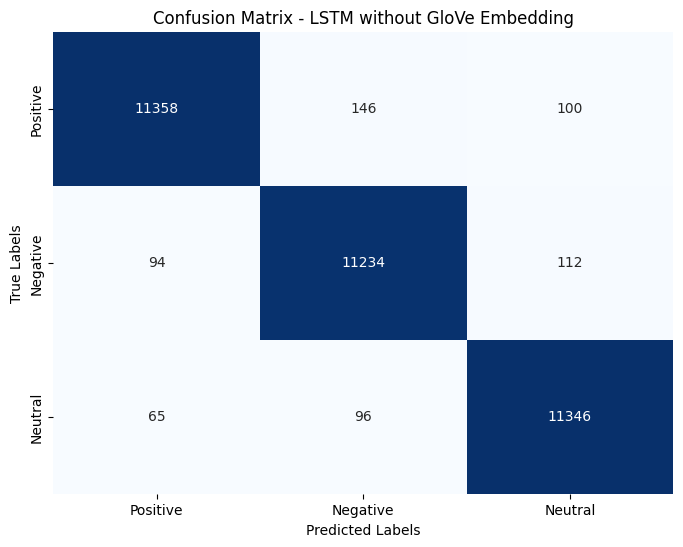

Classification Report - LSTM without GloVe Embedding:
              precision    recall  f1-score   support

    Positive       0.99      0.98      0.98     11604
    Negative       0.98      0.98      0.98     11440
     Neutral       0.98      0.99      0.98     11507

    accuracy                           0.98     34551
   macro avg       0.98      0.98      0.98     34551
weighted avg       0.98      0.98      0.98     34551



In [33]:
# Predict probabilities
y_pred_proba = model.predict(X_test)

# List of class labels
class_labels = ['Positive', 'Negative', 'Neutral']

# Evaluate the LSTM model without GloVe embeddings
evaluate_model(y_test, y_pred_proba, class_labels, model_name="LSTM without GloVe Embedding")

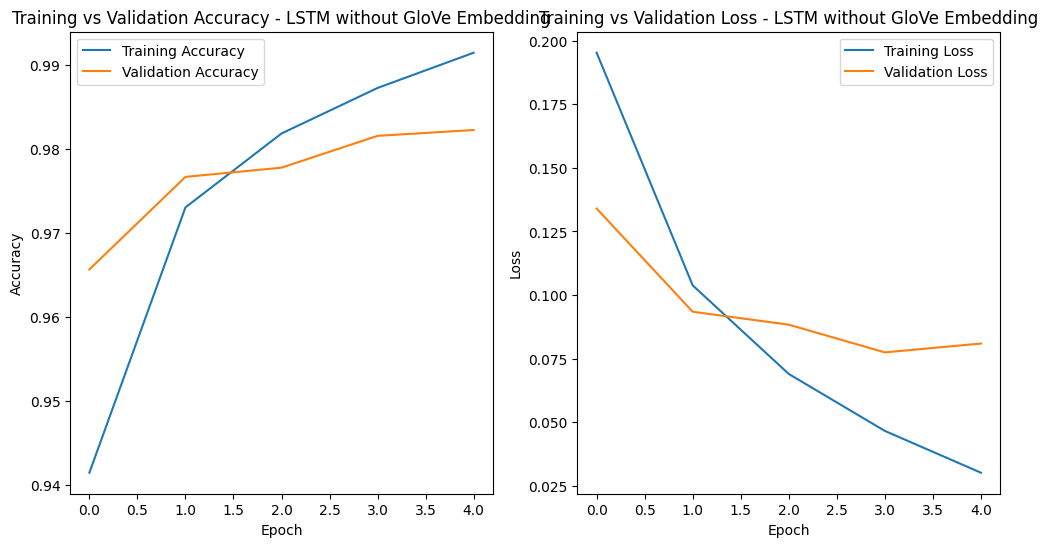

In [34]:
# Plot accuracy and loss for LSTM
plot_history(history_LSTM_no_glove, model_name="LSTM without GloVe Embedding")

#### TRAINING GRU CLASSIFIER

In [35]:
# Build the GRU model
model = Sequential()
model.add(Embedding(input_dim=len(word_index) + 1, 
                    output_dim=embedding_dim, 
                    input_length=max_sequence_length,
                    trainable=True))  # Set trainable to True to learn embeddings
model.add(GRU(units=64, return_sequences=True))
model.add(GRU(units=64))
model.add(Dense(num_classes, activation='softmax'))

In [36]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [44]:
# Train the GRU model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=32)

Epoch 1/5
4319/4319 ━━━━━━━━━━━━━━━━━━━━ 277s 63ms/step - accuracy: 0.7839 - loss: 0.5340 - val_accuracy: 0.9464 - val_loss: 0.1913
Epoch 2/5
4319/4319 ━━━━━━━━━━━━━━━━━━━━ 286s 66ms/step - accuracy: 0.9559 - loss: 0.1656 - val_accuracy: 0.9600 - val_loss: 0.1489
Epoch 3/5
4319/4319 ━━━━━━━━━━━━━━━━━━━━ 288s 67ms/step - accuracy: 0.9664 - loss: 0.1294 - val_accuracy: 0.9679 - val_loss: 0.1264
Epoch 4/5
4319/4319 ━━━━━━━━━━━━━━━━━━━━ 279s 65ms/step - accuracy: 0.9729 - loss: 0.1083 - val_accuracy: 0.9722 - val_loss: 0.1111
Epoch 5/5
4319/4319 ━━━━━━━━━━━━━━━━━━━━ 358s 73ms/step - accuracy: 0.9760 - loss: 0.0939 - val_accuracy: 0.9723 - val_loss: 0.1100


1080/1080 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step


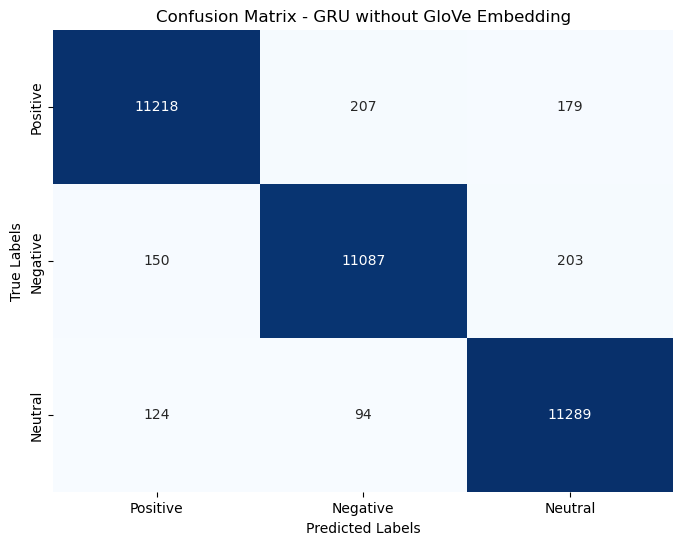

Classification Report - GRU without GloVe Embedding:
              precision    recall  f1-score   support

    Positive       0.98      0.97      0.97     11604
    Negative       0.97      0.97      0.97     11440
     Neutral       0.97      0.98      0.97     11507

    accuracy                           0.97     34551
   macro avg       0.97      0.97      0.97     34551
weighted avg       0.97      0.97      0.97     34551



In [45]:
# Predict probabilities
y_pred_proba = model.predict(X_test)

# Evaluate the GRU model without GloVe embeddings
evaluate_model(y_test, y_pred_proba, class_labels, model_name="GRU without GloVe Embedding")

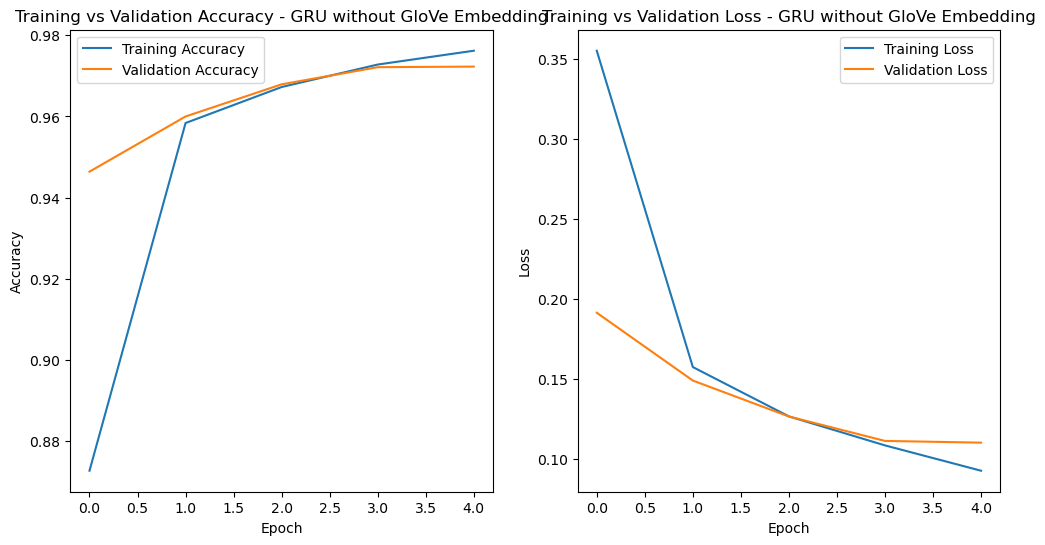

In [46]:
# Plot accuracy and loss for GRU
plot_history(history, model_name="GRU without GloVe Embedding")

#### TRAINING LSTM WITH GLOVE EMBEDDINGS

In [87]:
# Define the function to load GloVe embeddings and prepare the embedding matrix
def prepare_embedding_matrix(word_index, glove_file):
    embeddings_index = {}
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    embedding_dim = 100  # Ensure this matches the GloVe vectors you are using
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return embedding_matrix


In [88]:
# Assume balanced_data has been defined previously
X = balanced_data['clean_tweet']
y = balanced_data['sentiment']

In [89]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)
num_classes = y_categorical.shape[1] 


In [90]:

X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

In [91]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [92]:
# Access word_index from the tokenizer
word_index = tokenizer.word_index
max_sequence_length = 100  # Assume or calculate based on your data
embedding_dim = 100 

In [93]:
# Calculate the maximum sequence length before padding
max_sequence_length = max(max(len(seq) for seq in X_train_seq), max(len(seq) for seq in X_test_seq))

# Now pad sequences with the determined max length
X_train_padded = pad_sequences(X_train_seq, maxlen=max_sequence_length)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_sequence_length)

In [94]:
# Load GloVe embeddings and prepare the embedding matrix
glove_file = r"C:\Users\769800\OneDrive - hull.ac.uk\Downloads\glove.6B\glove.6B.100d.txt"
embedding_matrix = prepare_embedding_matrix(tokenizer.word_index, glove_file)"

In [95]:
# Build the LSTM model
model = Sequential([
    Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim,
              weights=[embedding_matrix], input_length=max_sequence_length, trainable=False),
    LSTM(units=64, return_sequences=True),
    LSTM(units=64),
    Dense(num_classes, activation='softmax')
])

In [96]:
# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [97]:
# Train the model
history_LSTM_glove = model.fit(X_train_padded, y_train, validation_data=(X_test_padded, y_test), epochs=5, batch_size=32)

Epoch 1/5
4319/4319 ━━━━━━━━━━━━━━━━━━━━ 85s 19ms/step - accuracy: 0.7783 - loss: 0.5384 - val_accuracy: 0.9472 - val_loss: 0.1780
Epoch 2/5
4319/4319 ━━━━━━━━━━━━━━━━━━━━ 84s 19ms/step - accuracy: 0.9548 - loss: 0.1542 - val_accuracy: 0.9636 - val_loss: 0.1266
Epoch 3/5
4319/4319 ━━━━━━━━━━━━━━━━━━━━ 81s 19ms/step - accuracy: 0.9703 - loss: 0.1047 - val_accuracy: 0.9726 - val_loss: 0.0953
Epoch 4/5
4319/4319 ━━━━━━━━━━━━━━━━━━━━ 91s 21ms/step - accuracy: 0.9780 - loss: 0.0794 - val_accuracy: 0.9773 - val_loss: 0.0816
Epoch 5/5
4319/4319 ━━━━━━━━━━━━━━━━━━━━ 88s 20ms/step - accuracy: 0.9839 - loss: 0.0594 - val_accuracy: 0.9741 - val_loss: 0.0926


1080/1080 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step


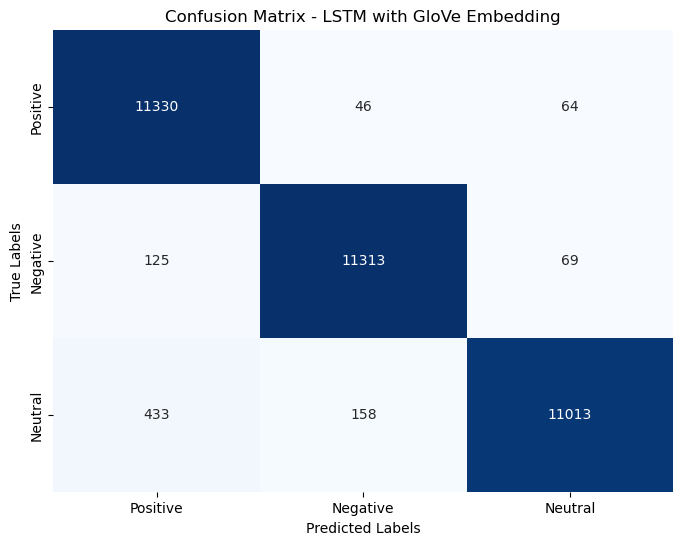

Classification Report - LSTM with GloVe Embedding:
              precision    recall  f1-score   support

    Positive       0.95      0.99      0.97     11440
    Negative       0.98      0.98      0.98     11507
     Neutral       0.99      0.95      0.97     11604

    accuracy                           0.97     34551
   macro avg       0.97      0.97      0.97     34551
weighted avg       0.97      0.97      0.97     34551



In [99]:
# Predict probabilities
y_pred_proba = model.predict(X_test_padded)

# List of class labels - ensure this matches the encoder or the number of output classes
class_labels = ['Positive', 'Negative', 'Neutral']  # Adjust as per your labels

# Evaluate the model
evaluate_model(y_test, y_pred_proba, class_labels, model_name="LSTM with GloVe Embedding")

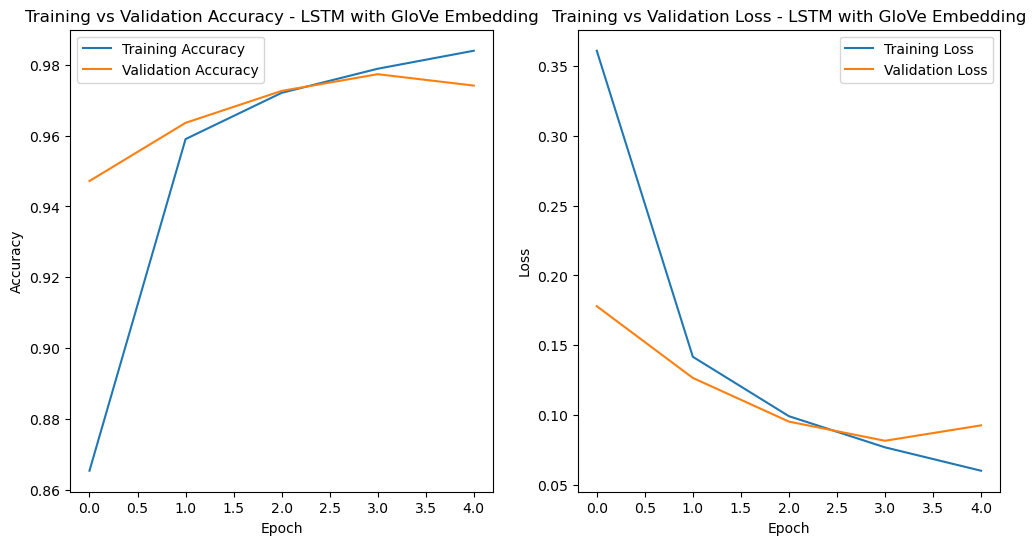

In [100]:
# Plot accuracy and loss for LSTM
plot_history(history_LSTM_glove, model_name="LSTM with GloVe Embedding")

#### LSTM WITH GLOVE EMBEDINGS (HYPER PARAMETER TUNNING)

In [102]:
# Specify the learning rate
learning_rate = 0.001  

# Build the LSTM model with hyperparameter tuning
model = Sequential([
    Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim,
              weights=[embedding_matrix], input_length=max_sequence_length, trainable=False),
    LSTM(units=64, return_sequences=True),  # Tune the number of units
    LSTM(units=64),  # Tune the number of units
    Dense(num_classes, activation='softmax')
])


In [103]:
# Compile the model with a tuned learning rate
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])


In [106]:
# Train the model with a tuned batch size
batch_size = 64 
epochs = 5

history_LSTM_tuned = model.fit(X_train_padded, y_train, validation_data=(X_test_padded, y_test), epochs=epochs, batch_size=batch_size)

# Model summary to check configurations
model.summary()


Epoch 1/5
2160/2160 ━━━━━━━━━━━━━━━━━━━━ 55s 26ms/step - accuracy: 0.9463 - loss: 0.1795 - val_accuracy: 0.9609 - val_loss: 0.1368
Epoch 2/5
2160/2160 ━━━━━━━━━━━━━━━━━━━━ 81s 25ms/step - accuracy: 0.9659 - loss: 0.1197 - val_accuracy: 0.9665 - val_loss: 0.1130
Epoch 3/5
2160/2160 ━━━━━━━━━━━━━━━━━━━━ 58s 27ms/step - accuracy: 0.9745 - loss: 0.0910 - val_accuracy: 0.9714 - val_loss: 0.1022
Epoch 4/5
2160/2160 ━━━━━━━━━━━━━━━━━━━━ 76s 24ms/step - accuracy: 0.9799 - loss: 0.0756 - val_accuracy: 0.9782 - val_loss: 0.0815
Epoch 5/5
2160/2160 ━━━━━━━━━━━━━━━━━━━━ 54s 25ms/step - accuracy: 0.9839 - loss: 0.0604 - val_accuracy: 0.9771 - val_loss: 0.0833


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ (None, 26, 100)        │    13,959,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 26, 64)         │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,186,279 (54.12 MB)

 Trainable params: 75,459 (294.76 KB)

 Non-trainable params: 13,959,900 (53.25 MB)

 Optimizer params: 150,920 (589.54 KB)

1080/1080 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step


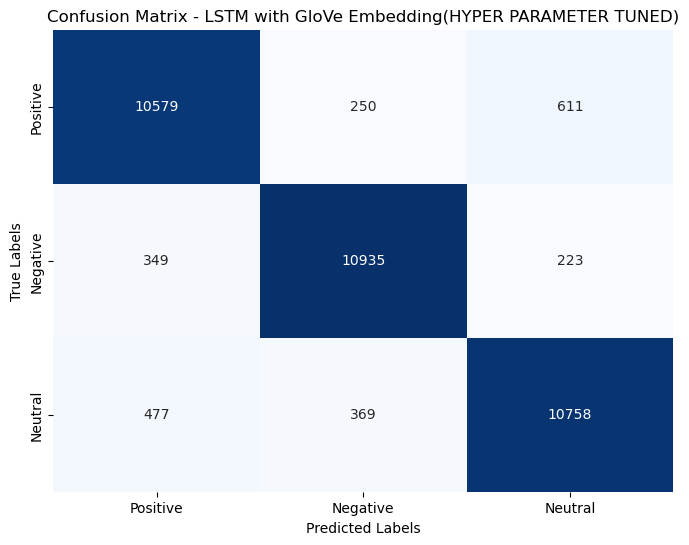

Classification Report - LSTM with GloVe Embedding(HYPER PARAMETER TUNED):
              precision    recall  f1-score   support

    Positive       0.93      0.92      0.93     11440
    Negative       0.95      0.95      0.95     11507
     Neutral       0.93      0.93      0.93     11604

    accuracy                           0.93     34551
   macro avg       0.93      0.93      0.93     34551
weighted avg       0.93      0.93      0.93     34551



In [105]:
# Predict probabilities
y_pred_proba = model.predict(X_test_padded)

# List of class labels - ensure this matches the encoder or the number of output classes
class_labels = ['Positive', 'Negative', 'Neutral']  # Adjust as per your labels

# Evaluate the model
evaluate_model(y_test, y_pred_proba, class_labels, model_name="LSTM with GloVe Embedding(HYPER PARAMETER TUNED)")


### GRU WITH GLOVE EMBEDINGS

In [107]:
# Build the GRU model
model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim,
              weights=[embedding_matrix], input_length=max_sequence_length, trainable=False),
    GRU(64, return_sequences=True),
    GRU(64),
    Dense(num_classes, activation='softmax')
])


In [108]:
# Compile the model with optimizer, loss function, and metrics
model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [109]:
# Explicitly build the model by specifying the input shape
model.build(input_shape=(None, max_sequence_length))

# Print the model summary to confirm build
model.summary()


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ (None, 26, 100)        │    13,959,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 26, 64)         │        31,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,016,927 (53.47 MB)

 Trainable params: 57,027 (222.76 KB)

 Non-trainable params: 13,959,900 (53.25 MB)

In [111]:
# Train the GRU model
history_GRU_glove = model.fit(X_train_padded, y_train, validation_data=(X_test_padded, y_test), epochs=5, batch_size=32)

Epoch 1/5
4319/4319 ━━━━━━━━━━━━━━━━━━━━ 101s 23ms/step - accuracy: 0.9162 - loss: 0.2608 - val_accuracy: 0.9463 - val_loss: 0.1729
Epoch 2/5
4319/4319 ━━━━━━━━━━━━━━━━━━━━ 94s 22ms/step - accuracy: 0.9584 - loss: 0.1416 - val_accuracy: 0.9615 - val_loss: 0.1272
Epoch 3/5
4319/4319 ━━━━━━━━━━━━━━━━━━━━ 98s 23ms/step - accuracy: 0.9710 - loss: 0.1000 - val_accuracy: 0.9723 - val_loss: 0.0987
Epoch 4/5
4319/4319 ━━━━━━━━━━━━━━━━━━━━ 142s 23ms/step - accuracy: 0.9797 - loss: 0.0746 - val_accuracy: 0.9731 - val_loss: 0.0969
Epoch 5/5
4319/4319 ━━━━━━━━━━━━━━━━━━━━ 101s 23ms/step - accuracy: 0.9841 - loss: 0.0584 - val_accuracy: 0.9782 - val_loss: 0.0796


1080/1080 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step


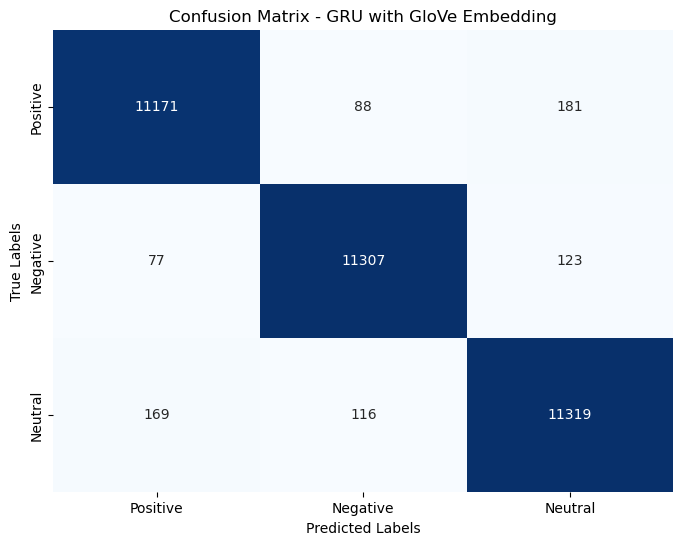

Classification Report - GRU with GloVe Embedding:
              precision    recall  f1-score   support

    Positive       0.98      0.98      0.98     11440
    Negative       0.98      0.98      0.98     11507
     Neutral       0.97      0.98      0.97     11604

    accuracy                           0.98     34551
   macro avg       0.98      0.98      0.98     34551
weighted avg       0.98      0.98      0.98     34551



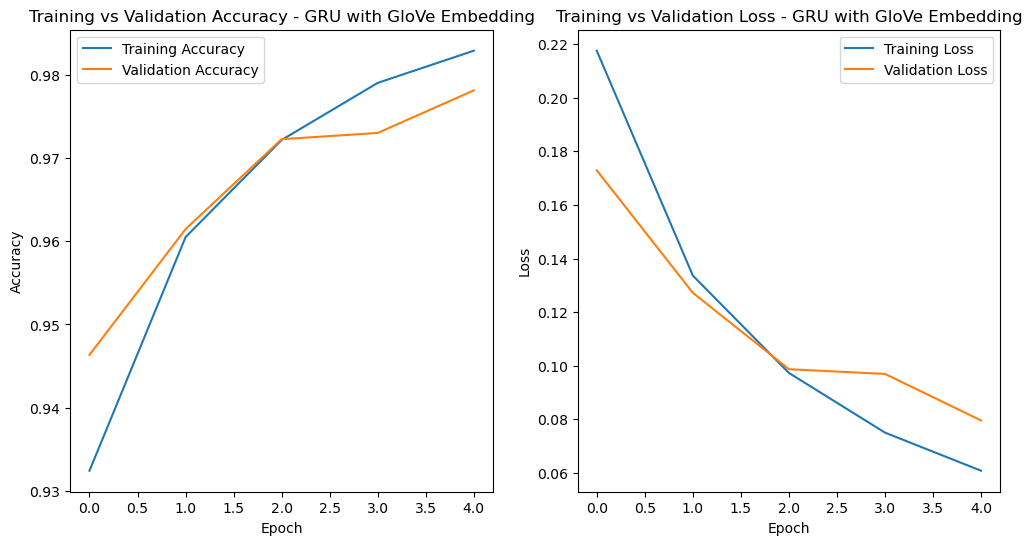

In [112]:
# Predict probabilities
y_pred_proba = model.predict(X_test_padded)

# List of class labels - ensure this matches the encoder or the number of output classes
class_labels = ['Positive', 'Negative', 'Neutral']  # Adjust as per your labels

# Evaluate the model
evaluate_model(y_test, y_pred_proba, class_labels, model_name="GRU with GloVe Embedding")

# Plot accuracy and loss for GRU
plot_history(history_GRU_glove, model_name="GRU with GloVe Embedding")


#### GRU WITH GLOVE EMBEDING(HYPER PARAMETER TUNED)

In [113]:
# Build the GRU model with hyperparameter tuning
model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim,
              weights=[embedding_matrix], input_length=max_sequence_length, trainable=False),
    GRU(64, return_sequences=True),
    GRU(128),
    Dense(num_classes, activation='softmax')
])

In [114]:
# Compile the model with appropriate optimizer and loss function
model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [115]:
# Call model.build() if needed to finalize the model setup
model.build(input_shape=(None, max_sequence_length))

# Check the model summary to confirm setup
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)        │ (None, 26, 100)        │    13,959,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_4 (GRU)                     │ (None, 26, 64)         │        31,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 128)            │        74,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,066,655 (53.66 MB)

 Trainable params: 106,755 (417.01 KB)

 Non-trainable params: 13,959,900 (53.25 MB)

In [117]:
# Train the GRU model with hyperparameter tuning
history_GRU_tuned = model.fit(X_train_padded, y_train, validation_data=(X_test_padded, y_test), epochs=5, batch_size=64)

Epoch 1/5
2160/2160 ━━━━━━━━━━━━━━━━━━━━ 74s 34ms/step - accuracy: 0.8610 - loss: 0.3864 - val_accuracy: 0.9443 - val_loss: 0.1890
Epoch 2/5
2160/2160 ━━━━━━━━━━━━━━━━━━━━ 98s 42ms/step - accuracy: 0.9475 - loss: 0.1739 - val_accuracy: 0.9596 - val_loss: 0.1403
Epoch 3/5
2160/2160 ━━━━━━━━━━━━━━━━━━━━ 84s 39ms/step - accuracy: 0.9650 - loss: 0.1217 - val_accuracy: 0.9659 - val_loss: 0.1148
Epoch 4/5
2160/2160 ━━━━━━━━━━━━━━━━━━━━ 131s 34ms/step - accuracy: 0.9736 - loss: 0.0936 - val_accuracy: 0.9745 - val_loss: 0.0947
Epoch 5/5
2160/2160 ━━━━━━━━━━━━━━━━━━━━ 86s 35ms/step - accuracy: 0.9794 - loss: 0.0730 - val_accuracy: 0.9715 - val_loss: 0.1001


1080/1080 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step


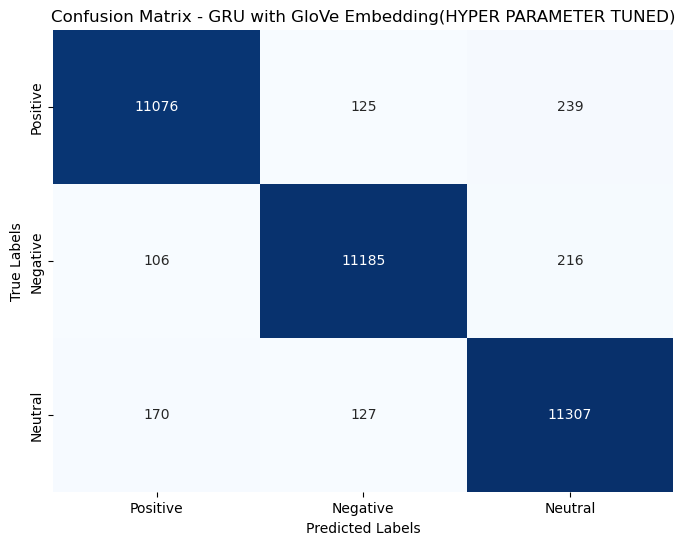

Classification Report - GRU with GloVe Embedding(HYPER PARAMETER TUNED):
              precision    recall  f1-score   support

    Positive       0.98      0.97      0.97     11440
    Negative       0.98      0.97      0.97     11507
     Neutral       0.96      0.97      0.97     11604

    accuracy                           0.97     34551
   macro avg       0.97      0.97      0.97     34551
weighted avg       0.97      0.97      0.97     34551



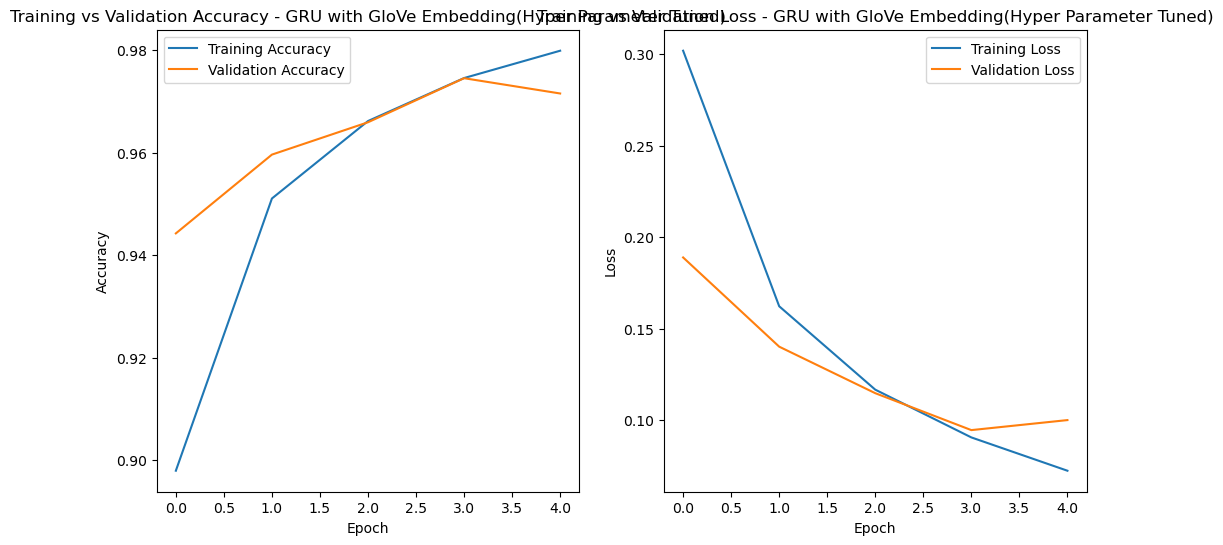

In [118]:
# Predict probabilities
y_pred_proba = model.predict(X_test_padded)

# List of class labels -
class_labels = ['Positive', 'Negative', 'Neutral']  

# Evaluate the model
evaluate_model(y_test, y_pred_proba, class_labels, model_name="GRU with GloVe Embedding(HYPER PARAMETER TUNED)")

# Plot accuracy and loss for GRU
plot_history(history_GRU_tuned, model_name="GRU with GloVe Embedding(Hyper Parameter Tuned)")